In [ ]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install pillow
!pip install diffusers
!pip install datasets
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install fsspec==2023.9.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.


## load dataset


In [ ]:
from PIL import Image
import numpy as n

In [ ]:
from datasets import load_dataset

dataset = load_dataset("huggan/selfie2anime", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## only wokring on the Anime Images

In [ ]:
dataset["imageB"]
# #

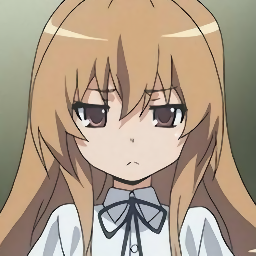

In [ ]:
img = dataset["imageB"][0]
img

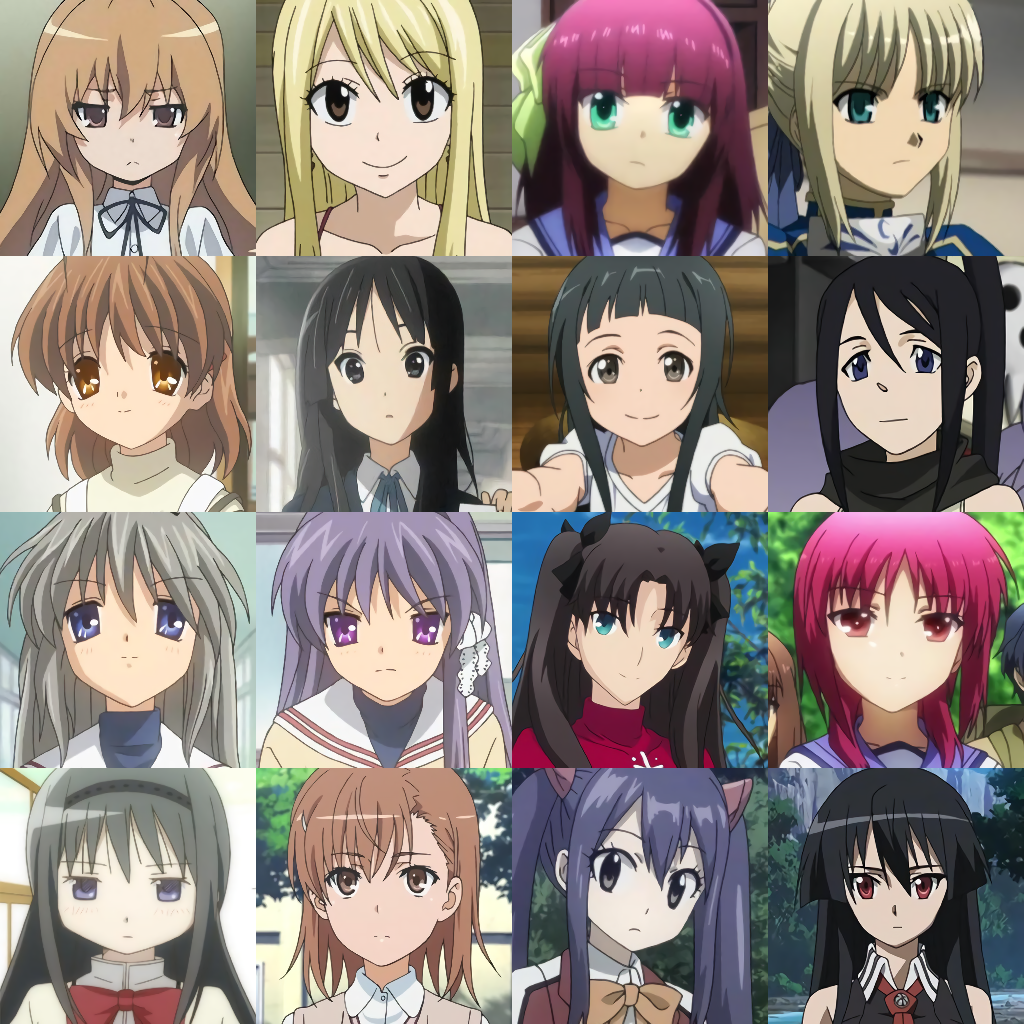

In [ ]:
from diffusers.utils import make_image_grid
make_image_grid(dataset["imageB"][:16], rows=4, cols=4)

## demonstration of adding noise to images


In [ ]:
import numpy as np

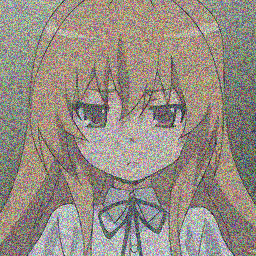

In [ ]:
noise = 256*np.random.rand(*img.size, 3)
noisy_img = ((img + noise)/2).astype(np.uint8)
Image.fromarray(noisy_img)

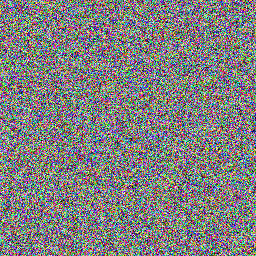

In [ ]:
Image.fromarray(noise.astype(np.uint8))


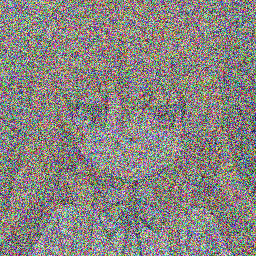

In [ ]:
more_noisy_img = ((img + 4*noise)/5).astype(np.uint8)
Image.fromarray(more_noisy_img)

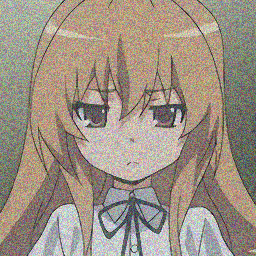

In [ ]:
less_noisy_img = ((img + 0.5*noise)/1.5).astype(np.uint8)
Image.fromarray(less_noisy_img)

## processing dataset


In [ ]:
from torchvision import transforms
IMAGE_SIZE=128

preprocess= transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
def transform(examples):
    images = [preprocess(image) for image in examples["imageB"]]
    return {"images": images}


In [ ]:
preprocess

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [ ]:
dataset.set_transform(transform)


In [ ]:
dataset

Dataset({
    features: ['imageA', 'imageB'],
    num_rows: 3400
})

Loading as Batch

In [ ]:
import torch
BSIZE = 16
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BSIZE, shuffle=True)

## adding noise to dataset


In [ ]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.34.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

## Demonstrated incremental amount of noise


In [ ]:
clean_images = next(iter(train_dataloader))["images"]
clean_images[0]

tensor([[[ 0.6392,  0.6392,  0.6392,  ...,  0.4118,  0.4745,  0.6078],
         [ 0.6392,  0.6392,  0.6392,  ...,  0.3961,  0.4118,  0.4275],
         [ 0.6392,  0.6392,  0.6392,  ...,  0.3882,  0.3961,  0.4039],
         ...,
         [ 0.9294,  0.9294,  0.9294,  ..., -0.5608, -0.4667, -0.3333],
         [ 0.9294,  0.9294,  0.9294,  ..., -0.5608, -0.4510, -0.3255],
         [ 0.9373,  0.9373,  0.9373,  ..., -0.5608, -0.4275, -0.3176]],

        [[ 0.8980,  0.8980,  0.8980,  ...,  0.3020,  0.3647,  0.5216],
         [ 0.8980,  0.8980,  0.8980,  ...,  0.2784,  0.2941,  0.3098],
         [ 0.8980,  0.8980,  0.8980,  ...,  0.2627,  0.2784,  0.2784],
         ...,
         [ 0.9686,  0.9686,  0.9686,  ..., -0.6314, -0.5373, -0.3961],
         [ 0.9686,  0.9686,  0.9686,  ..., -0.6314, -0.5137, -0.3804],
         [ 0.9686,  0.9686,  0.9686,  ..., -0.6314, -0.4980, -0.3725]],

        [[ 0.9451,  0.9529,  0.9529,  ...,  0.2078,  0.2706,  0.4431],
         [ 0.9529,  0.9529,  0.9529,  ...,  0

In [ ]:
# Sample noise to add to the images
noise = torch.randn(clean_images.shape, device=clean_images.device)
bs = clean_images.shape[0]

In [ ]:
# Sample a random timestep for each image
timesteps = torch.range(10, 161, 10, dtype=torch.int)
timesteps

/tmp/ipython-input-27-150040250.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  timesteps = torch.range(10, 161, 10, dtype=torch.int)


tensor([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
        150, 160], dtype=torch.int32)

In [ ]:
# Add noise to the clean images according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

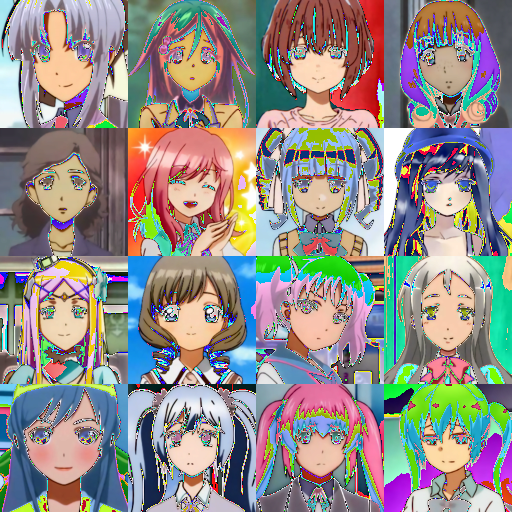

In [ ]:
make_image_grid([transforms.ToPILImage()(clean_image) for clean_image in clean_images], rows=4, cols=4)


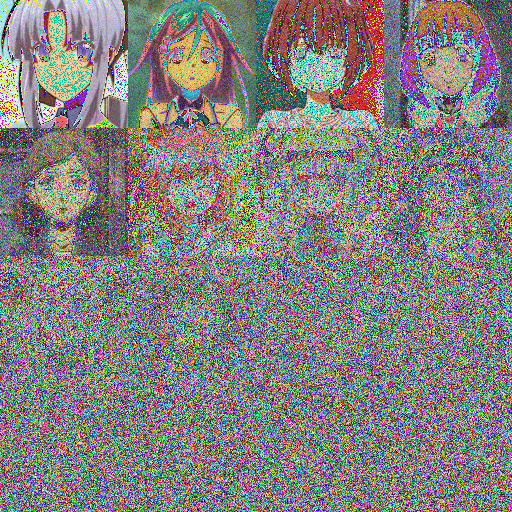

In [ ]:
make_image_grid([transforms.ToPILImage()(noisy_image) for noisy_image in noisy_images], rows=4, cols=4)

## Actual noise addition code


In [ ]:
clean_images = next(iter(train_dataloader))["images"]
# Sample noise to add to the images
noise = torch.randn(clean_images.shape, device=clean_images.device)
bs = clean_images.shape[0]

# Sample a random timestep for each image
timesteps = torch.randint(
    0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
    dtype=torch.int64
)

# Add noise to the clean images according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

## UNet model definition


In [ ]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
model


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

## UNet model training


### training setup


In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup
NUM_EPOCHS = 20
LR = 1e-4
LR_WARMUP_STEPS = 500

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=LR_WARMUP_STEPS,
    num_training_steps=(len(train_dataloader) * NUM_EPOCHS),
)

### model training loop


In [ ]:
import os
from accelerate import Accelerator
MODEL_SAVE_DIR = "anime-128"

# Initialize accelerator and tensorboard logging
accelerator = Accelerator(
    mixed_precision="fp16",
    log_with="tensorboard",
    project_dir=os.path.join(MODEL_SAVE_DIR, "logs"),
)

In [ ]:
if accelerator.is_main_process:
    if MODEL_SAVE_DIR is not None:
        os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    accelerator.init_trackers("train_example")

In [ ]:
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
from diffusers import DDPMPipeline

global_step = 0
SAVE_ARTIFACT_EPOCHS = 1
RANDOM_SEED = 42

# Now you train the model
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"]
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape, device=clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
            dtype=torch.int64
        )

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
        global_step += 1

    # After each epoch you optionally sample some demo images with evaluate() and save the model
    if accelerator.is_main_process:
        pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

        if (epoch + 1) % SAVE_ARTIFACT_EPOCHS == 0 or epoch == NUM_EPOCHS - 1:
            images = pipeline(
                batch_size=BSIZE,
                generator=torch.manual_seed(RANDOM_SEED),
            ).images

            # Make a grid out of the images
            image_grid = make_image_grid(images, rows=4, cols=4)

            # Save the images
            test_dir = os.path.join(MODEL_SAVE_DIR, "samples")
            os.makedirs(test_dir, exist_ok=True)
            image_grid.save(f"{test_dir}/{epoch:04d}.png")

            pipeline.save_pretrained(MODEL_SAVE_DIR)

Epoch 0: 100%|██████████| 213/213 [02:49<00:00,  1.39it/s, loss=0.0514, lr=4.26e-5, step=212]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 0: 100%|██████████| 213/213 [07:22<00:00,  2.08s/it, loss=0.0514, lr=4.26e-5, step=212]

Epoch 1: 100%|██████████| 213/213 [02:46<00:00,  1.52it/s, loss=0.0202, lr=8.52e-5, step=425]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 100%|██████████| 213/213 [02:46<00:00,  1.54it/s, loss=0.0136, lr=9.97e-5, step=638]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 2: 100%|██████████| 213/213 [07:18<00:00,  2.06s/it, loss=0.0136, lr=9.97e-5, step=638]

Epoch 3: 100%|██████████| 213/213 [02:47<00:00,  1.49it/s, loss=0.0118, lr=9.79e-5, step=851]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 100%|██████████| 213/213 [02:46<00:00,  1.56it/s, loss=0.0109, lr=9.45e-5, step=1064]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 4: 100%|██████████| 213/213 [07:12<00:00,  2.03s/it, loss=0.0109, lr=9.45e-5, step=1064]

Epoch 5: 100%|██████████| 213/213 [02:47<00:00,  1.47it/s, loss=0.01, lr=8.98e-5, step=1277]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 100%|██████████| 213/213 [02:46<00:00,  1.53it/s, loss=0.0094, lr=8.38e-5, step=1490]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 6: 100%|██████████| 213/213 [07:21<00:00,  2.07s/it, loss=0.0094, lr=8.38e-5, step=1490]

Epoch 7: 100%|██████████| 213/213 [02:47<00:00,  1.52it/s, loss=0.00877, lr=7.68e-5, step=1703]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 100%|██████████| 213/213 [02:46<00:00,  1.51it/s, loss=0.00826, lr=6.89e-5, step=1916]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 8: 100%|██████████| 213/213 [07:21<00:00,  2.07s/it, loss=0.00826, lr=6.89e-5, step=1916]

Epoch 9: 100%|██████████| 213/213 [02:48<00:00,  1.51it/s, loss=0.00787, lr=6.04e-5, step=2129]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 100%|██████████| 213/213 [02:46<00:00,  1.51it/s, loss=0.00764, lr=5.15e-5, step=2342]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 10: 100%|██████████| 213/213 [07:26<00:00,  2.10s/it, loss=0.00764, lr=5.15e-5, step=2342]

Epoch 11: 100%|██████████| 213/213 [02:48<00:00,  1.50it/s, loss=0.00731, lr=4.27e-5, step=2555]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 100%|██████████| 213/213 [02:46<00:00,  1.53it/s, loss=0.00677, lr=3.4e-5, step=2768] 

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 12: 100%|██████████| 213/213 [07:27<00:00,  2.10s/it, loss=0.00677, lr=3.4e-5, step=2768]

Epoch 13: 100%|██████████| 213/213 [02:48<00:00,  1.45it/s, loss=0.00623, lr=2.59e-5, step=2981]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 100%|██████████| 213/213 [02:46<00:00,  1.53it/s, loss=0.00586, lr=1.85e-5, step=3194]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 14: 100%|██████████| 213/213 [07:20<00:00,  2.07s/it, loss=0.00586, lr=1.85e-5, step=3194]

Epoch 15: 100%|██████████| 213/213 [02:48<00:00,  1.47it/s, loss=0.00539, lr=1.21e-5, step=3407]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 100%|██████████| 213/213 [02:46<00:00,  1.51it/s, loss=0.00513, lr=6.96e-6, step=3620]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 16: 100%|██████████| 213/213 [07:25<00:00,  2.09s/it, loss=0.00513, lr=6.96e-6, step=3620]

Epoch 17: 100%|██████████| 213/213 [02:48<00:00,  1.51it/s, loss=0.00496, lr=3.13e-6, step=3833]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 100%|██████████| 213/213 [02:46<00:00,  1.53it/s, loss=0.00486, lr=7.9e-7, step=4046] 

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 18: 100%|██████████| 213/213 [07:23<00:00,  2.08s/it, loss=0.00486, lr=7.9e-7, step=4046]

Epoch 19: 100%|██████████| 213/213 [02:49<00:00,  1.50it/s, loss=0.00483, lr=0, step=4259]       

  0%|          | 0/1000 [00:00<?, ?it/s]